In [6]:
import os, numpy as np, pandas as pd
import SimpleITK as sitk
import sys
sys.path.append('MAMAMIA')
from MAMAMIA.src.preprocessing import read_segmentation_from_patient_id
from MAMAMIA.src.visualization import get_segmentation_bounding_box
from MAMAMIA.src.clinical_data import *

In [7]:
dataset_path = r'E:\MAMA-MIA'
clinical_excel_path = dataset_path + r'\clinical_and_imaging_info.xlsx'
gt_segmentations_folder = dataset_path + r'\segmentations\expert'

# Load the clinical data 
clinical_data_df = pd.read_excel(clinical_excel_path, sheet_name='dataset_info')
display(clinical_data_df.head())
print(clinical_data_df.columns)

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,manufacturer,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,SIEMENS,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,GE,Signa HDxt,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,SIEMENS,Avanto,11,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,GE,Signa HDxt,15,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,GE,Signa HDxt,15,532.0,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...


Index(['patient_id', 'dataset', 'bilateral_breast_cancer', 'multifocal_cancer',
       'nac_agent', 'endocrine_therapy', 'anti_her2_neu_therapy', 'pcr',
       'mastectomy_post_nac', 'days_to_follow_up', 'days_to_recurrence',
       'days_to_metastasis', 'days_to_death', 'hr', 'er', 'pr', 'her2',
       'mammaprint', 'oncotype_score', 'nottingham_grade', 'tumor_subtype',
       'age', 'menopause', 'ethnicity', 'has_implant', 'weight',
       'patient_size', 'bmi_group', 'breast_density', 'view', 'bilateral_mri',
       'num_phases', 'fat_suppressed', 'field_strength', 'image_rows',
       'image_columns', 'num_slices', 'pixel_spacing', 'slice_thickness',
       'site', 'manufacturer', 'scanner_model', 'high_bit', 'window_center',
       'window_width', 'echo_time', 'repetition_time', 'acquisition_times',
       'acquisition_date', 'tcia_series_uid'],
      dtype='object')


In [3]:
filtered_data = filter_clinical_data(clinical_data_df, pcr=1)
filtered_data[filtered_data['dataset'] == 'DUKE'].head()

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,manufacturer,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,SIEMENS,Avanto,11,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,GE,Signa HDxt,15,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...
15,DUKE_044,DUKE,0,0.0,NaN,0.0,1.0,1.0,1.0,2170.0,...,SIEMENS,Avanto,11,133.0,288.0,1.390,4.120,"[0, 191, 291, 391, 491]",NaN,1.3.6.1.4.1.14519.5.2.1.1398300052156494317032...
16,DUKE_045,DUKE,0,1.0,NaN,0.0,1.0,1.0,0.0,1577.0,...,GE,SIGNA HDx,15,381.0,762.0,2.320,4.936,"[0, 146, 261, 376]",NaN,1.3.6.1.4.1.14519.5.2.1.3014405256878999537126...
20,DUKE_055,DUKE,0,0.0,NaN,0.0,0.0,1.0,0.0,664.0,...,GE,SIGNA HDx,15,705.0,1410.0,2.432,5.808,"[0, 326, 447, 568, 689]",NaN,1.3.6.1.4.1.14519.5.2.1.1963718232212781271399...


# Collect volumes of tumors

In [4]:
def getVolume(patient_id):
    segImg: sitk.Image = read_segmentation_from_patient_id(gt_segmentations_folder, patient_id)
    segArr = sitk.GetArrayFromImage(segImg)

    numVox = np.sum(segArr)
    volPerVox = np.prod(segImg.GetSpacing())

    return numVox * volPerVox       # return tumor volume in mm^3

In [8]:
from skimage.measure import marching_cubes, mesh_surface_area

def getSurfaceArea(patient_id):
    segImg: sitk.Image = read_segmentation_from_patient_id(gt_segmentations_folder, patient_id)
    segArr = sitk.GetArrayFromImage(segImg)

    v, f, _, _ = marching_cubes(segArr, level=0.5, spacing=segImg.GetSpacing()[::-1])

    return mesh_surface_area(v, f)

In [8]:
def getSizeOfTumor(patient_id):
    segImg: sitk.Image = read_segmentation_from_patient_id(gt_segmentations_folder, patient_id)
    return get_segmentation_bounding_box(segImg) 

In [16]:
clinical_data_df['tumor_size'] = clinical_data_df['patient_id'].apply(getSizeOfTumor)
display(clinical_data_df.head())

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_size
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,31 x 33 x 19
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,Signa HDxt,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,26 x 35 x 12
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,Avanto,11,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,40 x 25 x 46
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,Signa HDxt,15,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,44 x 54 x 24
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,Signa HDxt,15,532.0,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,75 x 81 x 27


In [33]:
def getSizes(size: str):
    return [int(s.strip()) for s in size.split('x')]
t = clinical_data_df['tumor_size'].apply(getSizes)

clinical_data_df['x_range'] = t.apply(lambda x: x[0])
clinical_data_df['y_range'] = t.apply(lambda x: x[1])
clinical_data_df['z_range'] = t.apply(lambda x: x[2])
display(clinical_data_df.head())

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_size,x_range,y_range,z_range
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,31 x 33 x 19,31,33,19
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,26 x 35 x 12,26,35,12
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,40 x 25 x 46,40,25,46
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,44 x 54 x 24,44,54,24
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,75 x 81 x 27,75,81,27


In [36]:
print(clinical_data_df['x_range'].min(), clinical_data_df['x_range'].max(), clinical_data_df['x_range'].mean(), clinical_data_df['x_range'].median())
print(clinical_data_df['y_range'].min(), clinical_data_df['y_range'].max(), clinical_data_df['y_range'].mean(), clinical_data_df['y_range'].median())
print(clinical_data_df['z_range'].min(), clinical_data_df['z_range'].max(), clinical_data_df['z_range'].mean(), clinical_data_df['z_range'].median())

9 228 53.61088977423639 46.0
10 228 61.202523240371846 52.0
4 120 25.36520584329349 21.0


In [6]:
clinical_data_df['tumor_volume'] = clinical_data_df['patient_id'].apply(getVolume)
display(clinical_data_df.head())

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_volume
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,5310.910970
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,Signa HDxt,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,764.001734
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,Avanto,11,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,12067.260742
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,Signa HDxt,15,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,5177.807148
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,Signa HDxt,15,532.0,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,15467.762020


In [9]:
clinical_data_df['tumor_surface_area'] = clinical_data_df['patient_id'].apply(getSurfaceArea)
display(clinical_data_df.head())

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_volume,tumor_surface_area
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,5310.910970,2211.571659
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,764.001734,942.481956
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,11,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,12067.260742,6298.429218
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,15,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,5177.807148,3765.642207
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,15,532.0,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,15467.762020,6391.890238


In [10]:
group_and_aggregate(clinical_data_df, group_by_column='pcr', agg_column='tumor_volume')

pcr
0.0    25792.742326
1.0    18342.376523
Name: tumor_volume, dtype: float64

In [11]:
group_and_aggregate(clinical_data_df, group_by_column='pcr', agg_column='tumor_surface_area')

pcr
0.0    9126.183992
1.0    6537.639897
Name: tumor_surface_area, dtype: float64

c:\Users\stoughth\Documents\mama-mia\MAMAMIA\src\clinical_data.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=numeric_column, data=data, palette="Set2")


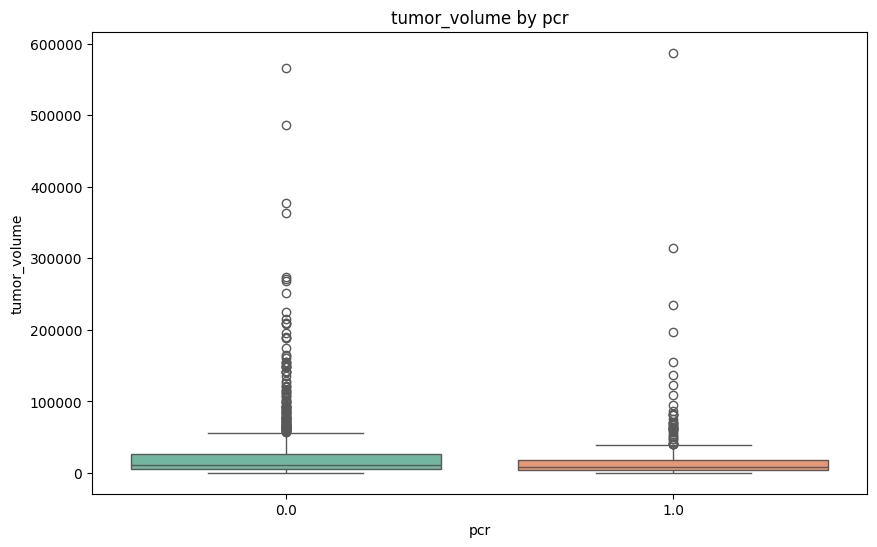

In [12]:
plot_comparison(clinical_data_df, 'tumor_volume', 'pcr')

c:\Users\stoughth\Documents\mama-mia\MAMAMIA\src\clinical_data.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=numeric_column, data=data, palette="Set2")


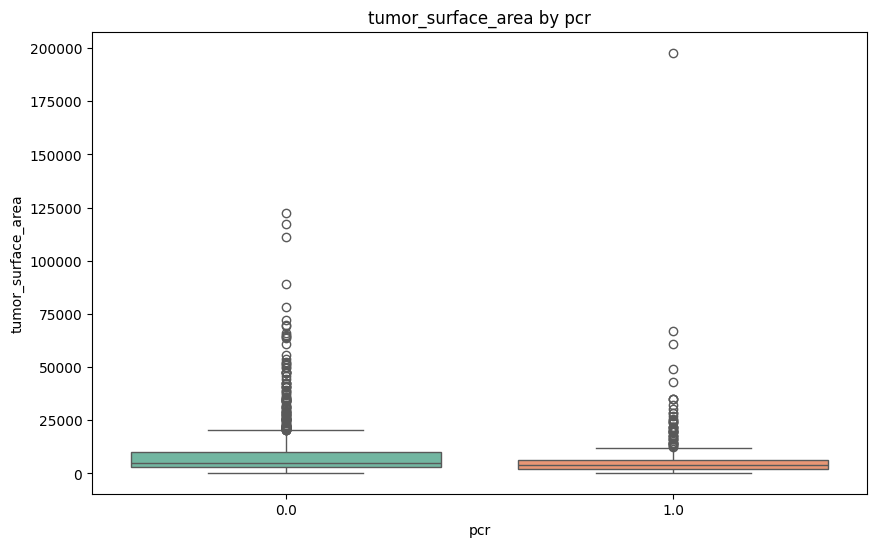

In [13]:
plot_comparison(clinical_data_df, 'tumor_surface_area', 'pcr')

In [25]:
df = clinical_data_df.copy()
age_bins = [0, 40, 50, 60, 70, float('inf')]
age_labels = ['0-40', '41-50', '51-60', '61-70', '71+']

# Apply binning to the age column
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)
def clean_menopause(entry):
    if pd.isna(entry):
        return 'unknown'  # or handle as appropriate
    first_word = str(entry).strip().lower().split()[0]
    if first_word == 'peri':
        return 'pre'
    elif first_word in ['pre', 'post']:
        return first_word
    else:
        return 'unknown'  # fallback for unexpected cases

df['menopause_clean'] = df['menopause'].apply(clean_menopause)
df

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_volume,tumor_surface_area,group,age_group,menopause_clean
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,5310.910970,2211.571659,41.0_pre_nan,41-50,pre
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,764.001734,942.481956,38.0_pre_nan,0-40,pre
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,12067.260742,6298.429218,38.0_pre_nan,0-40,pre
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,5177.807148,3765.642207,56.0_post_nan,51-60,post
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,15467.762020,6391.890238,67.0_post_nan,61-70,post
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,NACT_64,NACT,0,0.0,FEC100,NaN,NaN,0.0,1.0,705.0,...,4.200,8.400,"[0, 403, 751]",1994/02/23,1.3.6.1.4.1.14519.5.2.1.7695.2311.188949018082...,33645.019531,11005.034884,32.0_nan_nan,0-40,unknown
1502,NACT_65,NACT,0,0.0,Anthracycline,NaN,NaN,0.0,1.0,1448.0,...,4.200,8.000,"[0, 380, 686]",1992/06/16,1.3.6.1.4.1.14519.5.2.1.7695.2311.196765391224...,7654.064941,2837.491544,55.0_nan_nan,51-60,unknown
1503,NACT_66,NACT,0,0.0,Anthracycline,NaN,NaN,0.0,0.0,667.0,...,4.200,8.000,"[0, 362, 678, 962]",1992/01/07,1.3.6.1.4.1.14519.5.2.1.7695.2311.757338311647...,4129.102055,2279.738448,48.0_nan_nan,41-50,unknown
1504,NACT_67,NACT,0,0.0,Anthracycline,NaN,NaN,0.0,1.0,1234.0,...,4.200,11.000,"[0, 441, 947]",1988/04/21,1.3.6.1.4.1.14519.5.2.1.7695.2311.298593028606...,8798.827601,2904.979862,48.0_nan_nan,41-50,unknown


In [26]:
df['group'] = df.apply(lambda x: f"{x['age_group']}_{x['menopause_clean']}_{x['breast_density']}", axis=1)
print(df['group'].value_counts())

group
41-50_pre_nan        330
0-40_pre_nan         257
51-60_post_nan       214
41-50_unknown_nan    145
51-60_unknown_nan    133
61-70_post_nan       120
0-40_unknown_nan      76
51-60_pre_nan         61
61-70_unknown_nan     49
41-50_post_nan        33
71+_post_nan          12
41-50_pre_c           11
51-60_post_c          10
0-40_post_nan          8
41-50_pre_d            5
0-40_pre_d             5
61-70_post_b           5
71+_unknown_nan        5
51-60_post_b           4
41-50_post_c           3
51-60_pre_b            3
nan_pre_nan            3
71+_post_c             2
0-40_pre_c             2
61-70_post_a           2
71+_post_b             1
0-40_post_c            1
61-70_post_c           1
61-70_post_d           1
51-60_post_d           1
51-60_pre_c            1
41-50_post_b           1
51-60_post_a           1
Name: count, dtype: int64


# Train simple model to predict breast density

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.semi_supervised import LabelSpreading

# Step 1: Prepare the DataFrame
df_copy = df.copy()

# --- Clean menopause column ---
def clean_menopause(entry):
    if pd.isna(entry):
        return 'unknown'
    first_word = str(entry).strip().lower().split()[0]
    if first_word == 'peri':
        return 'pre'
    elif first_word in ['pre', 'post']:
        return first_word
    else:
        return 'unknown'

df_copy['menopause_clean'] = df_copy['menopause'].apply(clean_menopause)

# Step 2: Define feature columns and target
features = ['age', 'weight', 'ethnicity', 'menopause_clean']
target = 'breast_density'

# Step 3: Prepare features and label vector
X_raw = df_copy[features]
y_raw = df_copy[target]

# Convert y to -1 where labels are missing (required by LabelSpreading)
y_cat = y_raw.astype('category')
y_ssl = y_cat.cat.codes.to_numpy(copy=True)  # ✅ Make it writable

# Now assign -1 to unlabeled samples
y_ssl[y_raw.isna()] = -1

# Step 4: Define preprocessing pipeline
numeric_features = ['age', 'weight']
categorical_features = ['ethnicity', 'menopause_clean']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 5: Preprocess the full dataset
X_processed = preprocessor.fit_transform(X_raw)

# Step 6: Train the Label Spreading model
label_spread = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2)
label_spread.fit(X_processed, y_ssl)

# Step 7: Store the inferred labels
df_copy['breast_density_inferred'] = label_spread.transduction_

# Optional: Map integer labels back to original class names if available
if hasattr(y_raw, 'cat'):
    label_names = y_raw.cat.categories
    df_copy['breast_density_inferred'] = df_copy['breast_density_inferred'].map(lambda x: label_names[x] if x >= 0 and x < len(label_names) else np.nan)

# Optional: Check how many were inferred
print(f"Inferred labels for {df_copy['breast_density'].isna().sum()} missing entries.")


Inferred labels for 1446 missing entries.


In [54]:
df_copy["breast_density_inferred"] = df_copy["breast_density_inferred"].apply(lambda x: ['a', 'b', 'c', 'd'][x] if isinstance(x, int) and x >= 0 else x)

In [55]:
df_copy.loc[df_copy['breast_density'].notna(), ['breast_density', 'breast_density_inferred']]

,breast_density,breast_density_inferred
8,c,c
10,d,d
16,c,c
20,b,b
23,c,c
26,c,c
32,b,b
38,d,d
39,a,a
41,c,c


In [56]:
df_copy.columns

Index(['patient_id', 'dataset', 'bilateral_breast_cancer', 'multifocal_cancer',
       'nac_agent', 'endocrine_therapy', 'anti_her2_neu_therapy', 'pcr',
       'mastectomy_post_nac', 'days_to_follow_up', 'days_to_recurrence',
       'days_to_metastasis', 'days_to_death', 'hr', 'er', 'pr', 'her2',
       'mammaprint', 'oncotype_score', 'nottingham_grade', 'tumor_subtype',
       'age', 'menopause', 'ethnicity', 'has_implant', 'weight',
       'patient_size', 'bmi_group', 'breast_density', 'view', 'bilateral_mri',
       'num_phases', 'fat_suppressed', 'field_strength', 'image_rows',
       'image_columns', 'num_slices', 'pixel_spacing', 'slice_thickness',
       'site', 'manufacturer', 'scanner_model', 'high_bit', 'window_center',
       'window_width', 'echo_time', 'repetition_time', 'acquisition_times',
       'acquisition_date', 'tcia_series_uid', 'tumor_volume',
       'tumor_surface_area', 'group', 'age_group', 'menopause_clean',
       'breast_density_inferred'],
      dtype='obje

In [57]:
df_copy.to_excel(r"E:\MAMA-MIA\clinical_and_imaging_info_WITH_INFERRED_LABELS.xlsx", index=False)

# Simple Linear Model for pCR prediction from tumor shape

In [59]:
clinical_data_df['tumor_sa_v_ratio'] = clinical_data_df['tumor_surface_area'] / clinical_data_df['tumor_volume']
clinical_data_df.head()

,patient_id,dataset,bilateral_breast_cancer,multifocal_cancer,nac_agent,endocrine_therapy,anti_her2_neu_therapy,pcr,mastectomy_post_nac,days_to_follow_up,...,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,tumor_volume,tumor_surface_area,group,age_group,tumor_sa_v_ratio
0,DUKE_001,DUKE,0,0.0,NaN,0.0,1.0,0.0,0.0,2940.0,...,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,5310.910970,2211.571659,41.0_pre_nan,1.0,0.416420
1,DUKE_002,DUKE,0,0.0,NaN,0.0,0.0,0.0,0.0,1649.0,...,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,764.001734,942.481956,38.0_pre_nan,1.0,1.233612
2,DUKE_005,DUKE,0,1.0,NaN,0.0,1.0,1.0,1.0,1845.0,...,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,12067.260742,6298.429218,38.0_pre_nan,1.0,0.521944
3,DUKE_009,DUKE,0,1.0,NaN,0.0,0.0,1.0,0.0,1554.0,...,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,5177.807148,3765.642207,56.0_post_nan,2.0,0.727266
4,DUKE_010,DUKE,0,1.0,NaN,0.0,0.0,0.0,1.0,384.0,...,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,15467.762020,6391.890238,67.0_post_nan,3.0,0.413239


c:\Users\stoughth\Documents\mama-mia\MAMAMIA\src\clinical_data.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=numeric_column, data=data, palette="Set2")


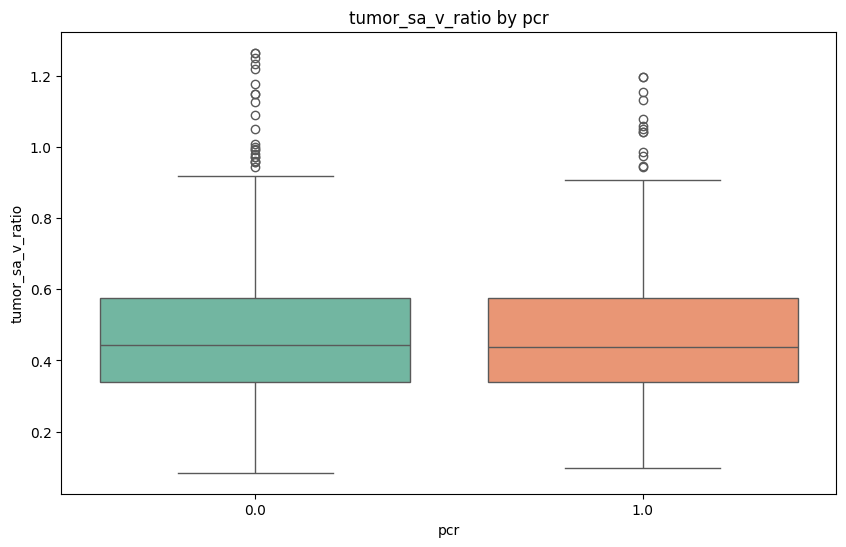

In [62]:
plot_comparison(clinical_data_df, 'tumor_sa_v_ratio', 'pcr')